In [ ]:
# Тут надо всё скачать

!pip install git+https://github.com/UKPLab/sentence-transformers
!pip install wordcloud
!pip install natasha

  Cloning https://github.com/UKPLab/sentence-transformers to /tmp/pip-req-build-8kxrh9q_
  Running command git clone --filter=blob:none --quiet https://github.com/UKPLab/sentence-transformers /tmp/pip-req-build-8kxrh9q_
  Resolved https://github.com/UKPLab/sentence-transformers to commit a458ce79c40fef93d5ecc66931b446ea65fdd017
  Preparing metadata (setup.py) ... done


In [ ]:
# скачивание датасета

!gdown 1eEeufOBE1O4cXmIJQwlvh0sz0k3qP8jT
!unzip -q MyVoice_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1eEeufOBE1O4cXmIJQwlvh0sz0k3qP8jT
To: /content/MyVoice_dataset.zip
100% 607k/607k [00:00<00:00, 85.7MB/s]
replace all/10106.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import pandas as pd
import numpy as np

import os

from pathlib import Path

from sentence_transformers import SentenceTransformer, util
import torch
from wordcloud import WordCloud

from natasha import MorphVocab

import json

### ML

In [ ]:
# Вот это основная функция
# В неё передаётся модель и json
# Возвращяется json и картинка PIL
# Ниже есть пример использования

def process_answers(model, data_json: dict):
    morph_vocab = MorphVocab()

    answers_json = data_json["answers"]

    data = [extract_answers(i) for i in answers_json]

    corpus = np.array([i[0] for i in data])
    true_clusters = np.array([i[1] for i in data])

    # corpus = np.array([morph_vocab.normal_forms(i[0]) if len(i[0]) < 2 else i[0] for i in corpus])

    codes = model.encode(corpus, convert_to_tensor=True, show_progress_bar=False)

    clusters = util.community_detection(codes, min_community_size=1, threshold=.75)

    # print(f"Вопрос: {data_json['question']}\n")

    full_text = ""

    for idx, cluster in enumerate(clusters):
        # print("\n".join([text + ' | ' + cluster for (text, cluster) in zip(corpus[cluster], true_clusters[cluster])]), end="\n-------------------\n")

        full_text += " ".join(corpus[cluster]) + '\n'

        for i in cluster:
            answers_json[i]["cluster"] = idx

    full_text_norm = ""

    for word in full_text.split():
        full_text_norm += morph_vocab.normal_forms(word)[0] + ' '

    wordcloud = WordCloud(
        background_color="white", max_words=5000,
        contour_width=3, contour_color='steelblue'
        ).generate(full_text_norm)

    return data_json, wordcloud.to_image()


def extract_answers(x):
    answer = x["corrected"] if "corrected" in x else x["answer"]
    cluster = x["cluster"] if "cluster" in x else ""

    return answer, cluster

In [ ]:
# Инициализация модели
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

In [ ]:
# считываем json
with open("labeled/26594.json", "r") as f:
    data_json = json.load(f)

In [ ]:
new_data, img = process_answers(model, data_json)

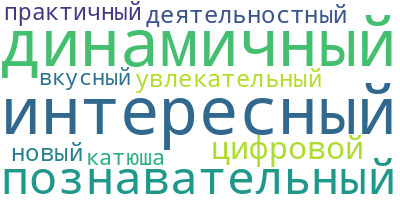

In [ ]:
img

In [ ]:
!pip install fastapi[all]
!pip install pyngrok

In [ ]:
!ngrok config add-authtoken

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

def process_answers(model, data_json: dict):
    morph_vocab = MorphVocab()

    answers = data_json["answers"]

    data = [extract_answers(i) for i in answers]

    corpus = np.array([i[0] for i in data])
    # true_clusters = np.array([i[1] for i in data])

    # corpus = np.array([morph_vocab.normal_forms(i[0]) if len(i[0]) < 2 else i[0] for i in corpus])

    codes = model.encode(corpus, convert_to_tensor=True, show_progress_bar=False)

    clusters = util.community_detection(codes, min_community_size=1, threshold=.75)

    # print(f"Вопрос: {data_json['question']}\n")

    full_text = ""

    for idx, cluster in enumerate(clusters):
        # print("\n".join([text + ' | ' + cluster for (text, cluster) in zip(corpus[cluster], true_clusters[cluster])]), end="\n-------------------\n")

        full_text += " ".join(corpus[cluster]) + '\n'

        for i in cluster:
            answers[i]["cluster"] = idx


    wordcloud = make_wordcloud(full_text, morph_vocab)

    sunburn = make_sunburn(answers, data_json["question"])

    return data_json, wordcloud.to_image(), sunburn.to_html()


def make_wordcloud(full_text, morph_vocab):
    full_text_norm = ""

    for word in full_text.split():
        full_text_norm += morph_vocab.normal_forms(word)[0] + ' '

    wordcloud = WordCloud(
        background_color="white", max_words=5000,
        contour_width=3, contour_color='steelblue'
        ).generate(full_text_norm)

    return wordcloud


def setup_color_pallet():
    colors = ["ff0a54","ff477e","ff5c8a","ff7096","ff85a1","ff99ac","fbb1bd","f9bec7","f7cad0","fae0e4"]
    colors = ['#' + i for i in colors]

    pio.templates["cluqwa"] = go.layout.Template(
        layout_colorway=colors
    )

    # setting Google color palette as default
    pio.templates.default = "cluqwa"


def make_sunburn(answers, question):
    # np_answers = np.array(answers)
    setup_color_pallet()

    data = pd.DataFrame(answers)

    # print(data)

    # data = data.astype(str)

    group = data[["cluster", "count"]].groupby("cluster").sum()

    # group = group.astype(str)

    # df = pd.DataFrame(answers)
    most_popular_answers = data.sort_values('count', ascending=False).drop_duplicates("cluster").sort_values("cluster")
    most_popular_answers = list(most_popular_answers["answer"])

    clusters_unique = list(map(str, group["count"].index))

    labels = list(most_popular_answers[int(i)] + ' ' for i in clusters_unique) + list(data["answer"])

    parents = [''] * len(clusters_unique) + list(most_popular_answers[int(i)] + ' ' for i in data["cluster"])

    values = list(group["count"]) + list(data["count"])

    fig = go.Figure(go.Sunburst(
        labels=labels,
        parents=parents,
        values=values,
    ))

    fig.update_layout(
        margin = dict(t=50, l=0, r=0, b=0),
        title=dict(text=question, yref='paper'),
        title_font={"size" : 25},
        title_x=.5,
)

    return fig


def extract_answers(x):
    answer = x["corrected"] if "corrected" in x else x["answer"]
    cluster = x["cluster"] if "cluster" in x else ""

    return answer, cluster

In [ ]:
import os
import sys
import json
import uvicorn
import nest_asyncio
import time
import re

from fastapi import FastAPI, File, UploadFile, Request, Response, HTTPException, Form
from fastapi.templating import Jinja2Templates
from fastapi.responses import FileResponse

from pyngrok import ngrok

from PIL import Image

app = FastAPI()
templates = Jinja2Templates(directory='templates')


@app.get('/')
def main(request: Request):
    return templates.TemplateResponse('main.html', {'request': request})

@app.get('/download') #todo for images and json files
def download_img(request: Request, filepath: str):
    if filepath:
        full_path = os.getcwd() + filepath
        filename = os.path.basename(filepath)
        headers = {'Content-Disposition': f'attachment; filename="{filename}"'}
        return FileResponse(full_path, headers=headers, media_type='json')

@app.post('/upload')
def upload(request: Request, file: UploadFile | None = File()):
    try:
        print(file)
        if file:

            #read json
            contents = file.file.read()
            data = json.loads(contents)

            st = time.time()
            new_data, img, html = process_answers(model, data)
            end = time.time()
            model_time = round(end - st, 4)

            #create path for image and json
            path = str(os.getcwd())
            file_id = int(time.time()*100)

            rel_img_path = '/output_data/wordcloud_images/' + f"{file_id}.png"
            rel_json_path = '/output_data/json/' + f"{file_id}.json"

            img_dest = path + rel_img_path
            json_dest = path + rel_json_path

            print(img_dest)
            print(json_dest)

            #save_img
            img.save(img_dest)

            #save json
            with open(json_dest, 'w', encoding='utf-8') as f:
                json.dump(new_data, f, ensure_ascii=False)
            print(img_dest)
            print(json_dest)

            #get html plot
            match = re.search(r"<div.*?>", html)
            end_index = match.end()
            html_plot = html[end_index:-16]

    except:
        raise HTTPException(status_code=500, detail='Something went wrong')
    finally:
        file.file.close()
    return templates.TemplateResponse(
        "cluster_plot.html",
        {
            "request":request,
            "json_path": rel_json_path,
            "html_plot": html_plot,
            "img_path": rel_img_path,
            "time": model_time
        }
    )

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

Public URL: https://741bfd0d3545.ngrok.app


INFO:     Started server process [2778]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     5.18.251.178:0 - "GET / HTTP/1.1" 200 OK
INFO:     5.18.251.178:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     35.237.4.214:0 - "GET / HTTP/1.1" 200 OK
INFO:     91.108.28.235:0 - "GET / HTTP/1.1" 200 OK
INFO:     91.108.28.235:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
/content/output_data/wordcloud_images/169432407017.png
/content/output_data/json/169432407017.json
/content/output_data/wordcloud_images/169432407017.png
/content/output_data/json/169432407017.json
INFO:     91.108.28.235:0 - "POST /upload HTTP/1.1" 200 OK
/content/output_data/wordcloud_images/169432466245.png
/content/output_data/json/169432466245.json
/content/output_data/wordcloud_images/169432466245.png
/content/output_data/json/169432466245.json
INFO:     5.18.251.178:0 - "POST /upload HTTP/1.1" 200 OK
INFO:     91.108.28.235:0 - "GET / HTTP/1.1" 200 OK
/content/output_data/wordcloud_images/169432474214.png
/content/output_data/json/169432474214.json
/content/output_data/wordcloud_images/16943

In [ ]:
!killall ngork

ngork: no process found
